# **Capítulo 3: Fontes de Dados Financeiros com Python**

Neste capítulo, vamos aprender a usar bibliotecas Python especializadas para buscar dados financeiros diretamente de fontes online, como cotações de ações, moedas e indicadores econômicos. Isso elimina a necessidade de baixar arquivos manualmente.

## **3.1 Bibliotecas para Dados Financeiros**

Existem diversas bibliotecas em Python para se conectar a fontes de dados (APIs). As duas que usaremos como principais exemplos são:

1.  **`yfinance`**: Uma biblioteca extremamente popular para baixar dados de cotações de ações, ETFs e índices do Yahoo Finance.
2.  **`python-bcb`**: Para obter séries temporais de dados econômicos brasileiros diretamente do Sistema Gerenciador de Séries Temporais (SGS) do Banco Central do Brasil.

### **3.1.1 yfinance: Cotações de Ações e Índices**

O `yfinance` é a ferramenta ideal para obter dados de ativos negociados em bolsa. Para ações brasileiras, usamos o mesmo código do home broker, adicionando o sufixo `.SA` (ex: `PETR4.SA`). A principal função que usaremos é a `yf.download()`.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install yfinance

Um passo fundamental após carregar um conjunto de dados é inspecioná-lo para garantir que tudo está correto. Vamos dar uma olhada nas primeiras e últimas linhas do nosso DataFrame da PETR4.

Para isso, usamos dois métodos muito úteis do Pandas:
* `.head()`: Exibe as 5 primeiras linhas.
* `.tail()`: Exibe as 5 últimas linhas.

In [ ]:
import yfinance as yf

# Baixando dados diários da Petrobras (PETR4) para o ano de 2023
# A função retorna um DataFrame do Pandas
petr4 = yf.download('PETR4.SA', start='2023-01-01', end='2023-12-31', auto_adjust=False)

# Exibindo as 5 primeiras linhas
print("--- Dados da PETR4 ---")
print(petr4.head())

# Exibindo as 5 últimas linhas
print("\n--- Fim dos Dados da PETR4 ---")
print(petr4.tail())

A função retorna um DataFrame com as seguintes colunas: `Open` (abertura), `High` (máxima), `Low` (mínima), `Close` (fechamento), `Adj Close` (fechamento ajustado para proventos) e `Volume`.

Também podemos baixar dados de múltiplos ativos de uma só vez.

In [ ]:
import yfinance as yf

# Definindo os tickers e o período
tickers = ['ITSA4.SA', 'VALE3.SA', '^BVSP']
start_date = '2023-01-01'
end_date = '2023-12-31'

# 1. Baixamos o DataFrame completo, com todos os dados (Open, High, Low, Close, etc.)
dados_completos = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 2. (Opcional) Vamos inspecionar a estrutura das colunas para entender
print("--- Estrutura das Colunas (MultiIndex) ---")
print(dados_completos.columns)

# 3. Agora, selecionamos o nível superior 'Adj Close'. Isso nos dará um DataFrame
#    apenas com os preços de fechamento ajustado de todos os tickers.
dados_adj_close = dados_completos['Adj Close']
dados_close = dados_completos['Close']

# 4. Exibindo as 5 primeiras linhas do resultado correto
print("\n--- DataFrame Apenas com 'Adj Close' ---")
print(dados_adj_close.head())
print("\n--- DataFrame Apenas com 'Close' ---")
print(dados_close.head())

### **3.1.2 Verificando e Corrigindo os Dados do yfinance (Tratando MultiIndex)**

Um passo crucial após baixar dados é sempre **verificar sua estrutura**. Dependendo da versão do `yfinance` ou do número de ativos baixados, os nomes das colunas podem vir em um formato chamado **MultiIndex** (nomes compostos, como `('Close', 'ITSA4.SA')`).

Bibliotecas de plotagem como a `mplfinance` esperam nomes de colunas simples (como `'Close'`). Se encontrarmos um MultiIndex, precisamos "achatá-lo" para usar os dados.

Vamos ver como diagnosticar e corrigir isso.

In [ ]:
import yfinance as yf
import pandas as pd

# 1. Baixamos os dados de um único ativo
itsa4 = yf.download('ITSA4.SA', start='2023-01-01', end='2023-12-31')

# 2. DIAGNÓSTICO: Verificamos como vieram os nomes das colunas
print("--- Nomes das Colunas Originais ---")
print(itsa4.columns)

# 3. CORREÇÃO: Se as colunas forem um MultiIndex, nós o "achatamos"
#    pegando apenas o primeiro nível dos nomes (ex: de ('Close', 'ITSA4.SA') para 'Close')
if isinstance(itsa4.columns, pd.MultiIndex):
    print("\nMultiIndex detectado. Corrigindo as colunas...")
    itsa4.columns = itsa4.columns.get_level_values(0)

# 4. VERIFICAÇÃO: Checamos os nomes das colunas novamente
print("\n--- Nomes das Colunas Corrigidos ---")
print(itsa4.columns)

# Agora o DataFrame está pronto para ser usado por outras bibliotecas!
print("\n--- Dados com Colunas Corrigidas ---")
print(itsa4.head())

### **3.1.3 python-bcb: Dados Econômicos do Banco Central do Brasil**

Para obter dados da economia brasileira, como a taxa Selic, IPCA, IGP-M ou a cotação do dólar, usamos a biblioteca `python-bcb`. Ela se conecta diretamente ao **SGS (Sistema Gerenciador de Séries Temporais)** do Banco Central do Brasil.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install python-bcb

Cada série de dados no Banco Central tem um código único. Para encontrar o código de uma série, podemos usar a função `sgs.search_sgs()`. Depois, usamos o código encontrado na função `sgs.get()` para baixar os dados.

In [ ]:
from bcb import sgs

# Vamos usar o código 11, que sabemos ser da taxa Selic diária.
# Passamos um dicionário onde a chave é o nome que queremos para a coluna ('Selic') 
# e o valor é o código (11).
selic = sgs.get({'Selic': 11}, start='2023-01-01')

print("--- Histórico da Taxa Selic Diária ---")
print(selic.tail()) # Usando .tail() para ver os dados mais recentes

In [ ]:
# Baixando os últimos 12 meses do IPCA (código 433) e do IGP-M (código 189)
inflacao = sgs.get({'IPCA': 433, 'IGP-M': 189}, last=12)

print("\n--- Últimos 12 meses de Inflação (IPCA vs IGP-M) ---")
print(inflacao.head())

A busca nos mostra que a taxa Selic diária tem o código **11**. Agora, vamos usar esse código para baixar os dados históricos.

In [ ]:
# Baixando a série da Selic a partir de 01/01/2023
# Passamos um dicionário onde a chave é o nome que queremos para a coluna e o valor é o código
selic = sgs.get({'Selic': 11}, start='2023-01-01')

print("--- Histórico da Taxa Selic Diária ---")
print(selic.head())

Também podemos baixar múltiplas séries de uma vez, passando um dicionário com vários códigos.

In [ ]:
# Baixando os últimos 12 meses do IPCA (código 433) e do IGP-M (código 189)
inflacao = sgs.get({'IPCA': 433, 'IGP-M': 189}, last=12)

print("--- Últimos 12 meses de Inflação (IPCA vs IGP-M) ---")
print(inflacao.head())

## **3.2 Manipulação de Séries Temporais com Pandas**

Tanto o `yfinance` quanto o `python-bcb` retornam DataFrames do Pandas, que são perfeitos para análise de séries temporais. A principal característica que torna isso possível é o **`DatetimeIndex`**, um tipo especial de índice composto por datas. Ter as datas como índice nos permite agrupar, fatiar e manipular os dados com base no tempo de forma muito eficiente.

In [ ]:
import yfinance as yf

# Vamos baixar um ativo de exemplo para esta seção
itsa4 = yf.download('ITSA4.SA', start='2022-01-01', end='2023-12-31')

# Vamos verificar o tipo do índice do nosso DataFrame
print(f"O tipo do índice é: {type(itsa4.index)}")

print("\nVisualizando os dados:")
print(itsa4.head())

Um DataFrame com `DatetimeIndex` tem dois componentes principais que podemos acessar separadamente:
* **`.index`**: O objeto que contém todas as datas (o índice).
* **`.values`**: Um array NumPy contendo todos os valores numéricos do DataFrame (os dados em si).

In [ ]:
# Acessando apenas o índice (as datas)
print("--- Objeto de Índice (Datas) ---")
print(itsa4.index)


# Acessando apenas os valores (como uma matriz)
print("\n--- Array de Valores ---")
print(itsa4.values)

### Convertendo a Periodicidade (Resample)

Uma das tarefas mais comuns é mudar a frequência dos dados (ex: de diário para mensal). No Pandas, fazemos isso com o método `.resample()`. Ele agrupa os dados por uma nova frequência e depois aplicamos uma função de agregação (como `.last()`, `.first()`, `.sum()`, `.mean()`) para definir como os dados agrupados devem ser representados.

Usamos códigos para definir a frequência:
* `M`: Fim do Mês (`Month End`)
* `MS`: Início do Mês (`Month Start`)
* `Q`: Fim do Trimestre (`Quarter End`)
* `Y`: Fim do Ano (`Year End`)

In [ ]:
# Resample para dados mensais, pegando o último preço de cada mês
itsa4_mensal = itsa4.resample('ME').last()
print("--- Dados Mensais (Último dia do Mês) ---")
print(itsa4_mensal.head())

# Resample para dados trimestrais, calculando o preço médio de cada trimestre
itsa4_trimestral = itsa4.resample('QE').mean()
print("\n--- Dados Trimestrais (Média do Trimestre) ---")
print(itsa4_trimestral.head())

### Movendo o Índice de Data para uma Coluna

Às vezes, é útil ter a data como uma coluna normal do DataFrame em vez de ser o índice. Para fazer isso, usamos o método `.reset_index()`.

In [ ]:
# Criando uma cópia para não alterar nosso DataFrame original
itsa4_com_coluna_data = itsa4.reset_index()

print("--- DataFrame com a data como coluna ---")
print(itsa4_com_coluna_data.head())

## **3.3 Selecionando Colunas Específicas (Open, High, Low, Close)**

Diferente de algumas bibliotecas do R, o Pandas não precisa de funções "ajudantes" (helpers) para selecionar colunas específicas como `Open`, `High`, `Low` ou `Close`.

A seleção é feita de forma direta e intuitiva, simplesmente passando o nome da coluna desejada entre colchetes `[]` no DataFrame. O resultado será uma `Series` do Pandas contendo apenas os dados daquela coluna.

In [ ]:
# Usando o DataFrame 'itsa4' que já baixamos e o dados_adj_close que fizemos no 3.1.1

# Selecionar apenas a coluna de Fechamento ('Close')
precos_fechamento = itsa4['Close']
print("--- Apenas Preços de Fechamento ---")
print(precos_fechamento.head())


# Selecionar apenas a coluna de Abertura ('Open')
precos_abertura = itsa4['Open']
print("\n--- Apenas Preços de Abertura ---")
print(precos_abertura.head())


# Selecionar apenas a coluna de Preço Máximo ('High')
precos_maximos = itsa4['High']
print("\n--- Apenas Preços Máximos ---")
print(precos_maximos.head())


# Selecionar a coluna de Fechamento Ajustado ('Adj Close') usando o DataFrame correto
precos_ajustados = dados_adj_close['ITSA4.SA']
print("\n--- Apenas Preços de Fechamento Ajustado (ITSA4.SA) ---")
print(precos_ajustados.head())

## **3.4 Gráficos Financeiros com mplfinance**

Embora possamos fazer gráficos de linha com Seaborn, para visualizações financeiras mais completas (como gráficos de candlestick com volume), usamos uma biblioteca especializada chamada `mplfinance`. Ela é o equivalente direto da função `chartSeries` do R e foi criada para trabalhar perfeitamente com DataFrames do Pandas.

Primeiro, você precisa instalar a biblioteca no seu terminal.

**No seu terminal (apenas uma vez):**
```bash

In [ ]:
pip install mplfinance

In [ ]:
import yfinance as yf
import mplfinance as mpf

# Vamos usar o DataFrame 'itsa4' que já temos
# Caso não o tenha, rode novamente:
itsa4 = yf.download('ITSA4.SA', start='2022-01-01', end='2023-12-31')

# Observando a estrutura do DataFrame, note que as colunas podem estar em MultiIndex
print(itsa4.info())
# Tratando o MultiIndex
if isinstance(itsa4.columns, pd.MultiIndex):
    print("\nMultiIndex detectado. Corrigindo as colunas...")
    itsa4.columns = itsa4.columns.get_level_values(0)


# A função mpf.plot() é a principal da biblioteca.
# Por padrão, ela já cria um gráfico de linha para o preço e um painel separado para o volume.
mpf.plot(itsa4, 
         type='line', 
         title='ITSA4 - 2022 a 2023', 
         ylabel='Preço (R$)',
         volume=True, 
         ylabel_lower='Volume',
         style='yahoo')


A grande vantagem do `mplfinance` é a facilidade para criar gráficos de candlestick. Basta mudar o argumento `type` para `'candle'`. Vamos visualizar apenas os últimos 60 dias de pregão para que os candles fiquem mais visíveis.

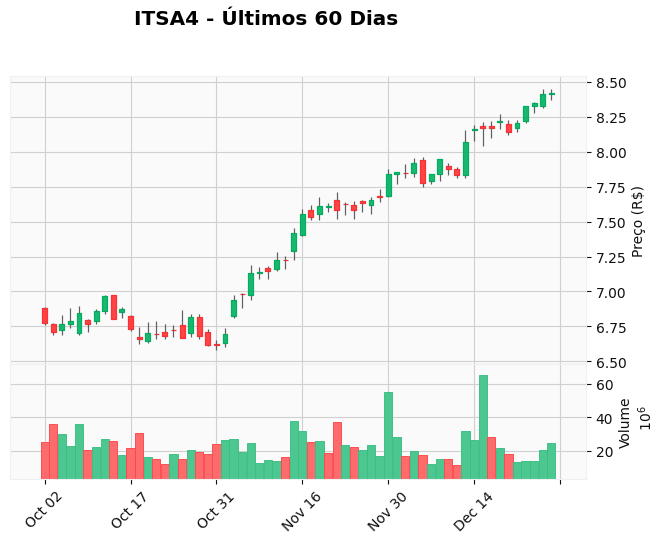

In [ ]:
# Pegando os últimos 60 dias de dados do nosso DataFrame
itsa4_recente = itsa4.tail(60)

# Criando o gráfico de candlestick
mpf.plot(itsa4_recente, 
         type='candle', 
         title='ITSA4 - Últimos 60 Dias', 
         ylabel='Preço (R$)',
         volume=True, 
         ylabel_lower='Volume',
         style='yahoo')

## **3.5 Juntar Múltiplas Séries Temporais**

Na maioria das vezes, especialmente em análise de portfólios, precisamos comparar múltiplos ativos. A melhor forma de fazer isso é ter todas as séries de preços em um único DataFrame, com as datas perfeitamente alinhadas.

No Pandas, a função `pd.concat()` é ideal para isso. Ela "cola" as séries de dados lado a lado (como colunas), usando o índice de datas para garantir que os preços do "dia X" de um ativo fiquem na mesma linha do "dia X" dos outros.

In [31]:
import yfinance as yf
import pandas as pd

# --- Passo 1: Baixar os dados de cada ativo separadamente ---
# (Para este exemplo, vamos pegar dados mensais para simplificar a visualização)
petr4 = yf.download('PETR4.SA', start='2022-01-01', end='2023-12-31', interval='1mo', auto_adjust=False)
bbdc4 = yf.download('BBDC4.SA', start='2022-01-01', end='2023-12-31', interval='1mo', auto_adjust=False)
ibov = yf.download('^BVSP', start='2022-01-01', end='2023-12-31', interval='1mo', auto_adjust=False)


# --- Passo 2: Selecionar a coluna de interesse de cada ativo (ex: 'Adj Close') ---
petr4_adj = petr4['Adj Close']
bbdc4_adj = bbdc4['Adj Close']
ibov_adj = ibov['Adj Close']


# --- Passo 3: Usar pd.concat para juntar as séries em um único DataFrame ---
# Criamos uma lista com as Series que queremos juntar
lista_de_series = [petr4_adj, bbdc4_adj, ibov_adj]

# axis=1 significa que queremos "colar" as séries como colunas, lado a lado
portfolio = pd.concat(lista_de_series, axis=1)


# --- Passo 4: Renomear as colunas para facilitar a identificação ---
portfolio.columns = ['PETR4', 'BBDC4', 'IBOV']


# --- Passo 5: Visualizar o resultado ---
print("--- DataFrame Combinado ---")
print(portfolio.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

--- DataFrame Combinado ---
                PETR4      BBDC4      IBOV
Date                                      
2022-01-01  11.790812  16.087700  112388.0
2022-02-01  12.392198  14.372829  113142.0
2022-03-01  12.191735  15.706600  119999.0
2022-04-01  11.036346  13.993476  107876.0
2022-05-01  11.985994  15.968533  111351.0


Embora seja importante saber juntar dados manualmente, a biblioteca `yfinance` permite baixar os dados de múltiplos ativos de uma só vez, o que é bem mais prático!

In [ ]:
tickers = ['PETR4.SA', 'BBDC4.SA', '^BVSP']

portfolio_rapido = yf.download(tickers, start='2022-01-01', end='2023-12-31', interval='1mo', auto_adjust=False)['Adj Close']

print(portfolio_rapido.head())

## **3.6 Case Prático: Calculando o IBOVESPA em Dólar**

[cite_start]Neste case, vamos aplicar nossas habilidades para criar uma nova série de dados: o valor do índice IBOVESPA cotado em dólares americanos[cite: 2769, 2774]. Isso nos permite analisar o desempenho da bolsa brasileira sob a perspectiva de um investidor estrangeiro.

O processo será:
1.  Baixar a série de pontos do IBOVESPA (`^BVSP`) usando o `yfinance`.
2.  Baixar a série da taxa de câmbio PTAX de Dólar para Real (venda) usando o `python-bcb`.
3.  Juntar e alinhar as duas séries de dados.
4.  Dividir os pontos do IBOVESPA pela cotação do dólar.
5.  Visualizar o resultado.

In [48]:
import yfinance as yf
from bcb import sgs
import pandas as pd
import matplotlib.pyplot as plt

dolar = sgs.get({'USDBRL': 1}, start='2020-01-01', end='2023-12-31')
print(dolar.head())
if isinstance(dolar.columns, pd.MultiIndex):
    dolar.columns = dolar.columns.get_level_values(0)
    
print(dolar.head())

            USDBRL
Date              
2020-01-02  4.0213
2020-01-03  4.0522
2020-01-06  4.0554
2020-01-07  4.0841
2020-01-08  4.0672
            USDBRL
Date              
2020-01-02  4.0213
2020-01-03  4.0522
2020-01-06  4.0554
2020-01-07  4.0841
2020-01-08  4.0672


In [ ]:
import yfinance as yf
from bcb import sgs
import pandas as pd
import matplotlib.pyplot as plt

# --- Passo 1: Baixar os dados e tratar multindex ---
print("Baixando dados...")
ibov_df = yf.download('^BVSP', start='2020-01-01', end='2023-12-31')
dolar_df = sgs.get({'USDBRL': 1}, start='2020-01-01', end='2023-12-31')

print(ibov_df.columns)

if isinstance(ibov_df.columns, pd.MultiIndex):
    print("\nMultiIndex detectado no IBOV. Corrigindo as colunas...")
    ibov_df.columns = ibov_df.columns.get_level_values(0)

print(ibov_df.columns)

# --- Passo 2: Selecionar APENAS a Series de dados que nos interessa de cada tabela ---
# Para o IBOV, pegamos a coluna 'Close'
ibov_series = ibov_df['Close']
# Para o Dólar, pegamos a coluna 'USDBRL'
dolar_series = dolar_df['USDBRL']


# --- Passo 3: Juntar as duas Series em um novo DataFrame ---
# O Pandas usará automaticamente os nomes das Series como nomes das colunas
dados_combinados = pd.concat([ibov_series, dolar_series], axis=1)


# --- Passo 4: Tratar dados faltantes (feriados, etc.) ---
# .fillna(method='ffill') preenche dias sem dados com o último valor válido
dados_combinados = dados_combinados.fillna(method='ffill')
dados_combinados = dados_combinados.dropna() # Remove qualquer linha que ainda esteja vazia


# --- Passo 5: Calcular o IBOVESPA em Dólar ---
# Agora os nomes das colunas são simples e o cálculo funciona!
dados_combinados['IBOV_USD'] = dados_combinados['Close'] / dados_combinados['USDBRL']


# --- Passo 6: Visualizar o resultado ---
print("\n--- Tabela Final com IBOV em USD ---")
print(dados_combinados.tail())

# Plotando o gráfico
dados_combinados['IBOV_USD'].plot(figsize=(12, 6), title='IBOVESPA em Dólar (USD)')
plt.ylabel('Pontos (USD)')
plt.grid(True)
plt.show()

Parabéns por concluir o Capítulo 3!

Você agora tem uma base sólida para obter e preparar dados financeiros em Python. Você aprendeu a:
* Baixar cotações de ações com `yfinance`.
* Obter dados macroeconômicos do Banco Central com `python-bcb`.
* Manipular e converter a periodicidade de séries temporais com `pandas`.
* Juntar diferentes conjuntos de dados e realizar cálculos entre eles.

Com essas habilidades, estamos prontos para começar a **análise** desses dados no **Capítulo 4: Análise de Retornos**.